### Useful imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import models, activations, layers, metrics, optimizers, regularizers, callbacks

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### Load CSV

In [2]:
dataset = pd.read_csv("income.csv", header=0, skipinitialspace=True)
del dataset['Unnamed: 0']

### Useful python functions

In [3]:
def replace_on_condition(dataset, column_name, condition_value, replace_value):
    condition = dataset.loc[:, column_name].str.contains(condition_value)
    dataset.loc[condition, column_name] = replace_value
    
    return dataset

north_america = ['United-States', 'Cuba', 'Jamaica', 'Mexico', 'Honduras', 'Canada', 'Puerto-Rico', 'Outlying']
south_america = ['South', 'Philippines', 'Columbia', 'Cambodia', 'Ecuador', 'Haiti', 'Dominican-Republic', 'El-Salvador', 'Guatemala', 'Peru', 'Outlying-US(Guam-USVI-etc)', 'Trinadad&Tobago', 'Nicaragua']
asia = ['India', 'Iran', 'Thailand', 'Laos', 'Taiwan', 'China', 'Japan', 'Vietnam', 'Hong']
europe = ['England', 'Germany', 'Italy', 'Poland', 'Portugal', 'France', 'Yugoslavia', 'Scotland', 'Greece', 'Ireland', 'Hungary', 'Holand-Netherlands']
other = ['\?']

def replace_native_country(dataset, values, replacement):
    for value in values:
        dataset = replace_on_condition(dataset, "native country", value, replacement)
    
    return dataset

def standardize_number(dataframe, column_name):
    return (dataframe[column_name] - dataframe[column_name].mean()) / dataframe[column_name].std()

def expand_category(dataframe, column_name):
    expanded_dataframe = pd.concat([dataframe, pd.get_dummies(dataframe[column_name], prefix=column_name)], axis=1)

    expanded_dataframe.drop([column_name], axis=1, inplace=True)

    return expanded_dataframe

def unison_shuffled_copies(a, b):
    mask = np.random.permutation(len(a))
    return a[mask], b[mask]

def predict_and_plot(n, inputs, outputs):
    selection = np.arange(n)

    predicted = model.predict(inputs)[selection]

    absolute_distance_from_outputs = np.abs(outputs[selection] - predicted)
    missclassified_number = np.sum((absolute_distance_from_outputs > 0.5) * 1.0)
    
    plt.figure(figsize=(20,3))
    plt.plot(np.zeros(n), 'b')
    plt.plot(np.ones(n) * 0.5, 'b')
    plt.plot(np.ones(n), 'b')
    plt.plot(absolute_distance_from_outputs, 'xr')
    
    print(str(missclassified_number / n * 100) + "%")
    plt.show()
    
def show_categorical_distribution(column):
    print(dataset.groupby([column])[column].count())

def plot_categorical_distribution(column, label_rotation = 0):
    sns.countplot(x=column, data=dataset)
    plt.xticks(rotation=label_rotation)
    plt.show()
    
def plot_numerical_distribution(column, label_rotation = 0):
    plt.xticks(rotation=label_rotation)
    plt.hist(dataset[column])
    plt.show()

In [4]:
dataset.head()

,age,workclass,fnlwgt,education,education num,marital status,occupation,relationship,race,m_f,capital gain,capital loss,hours/week,native country,income bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
show_categorical_distribution("race")

condition = dataset.loc[:, "race"] == "Wite"
dataset.loc[condition, "race"] = "White"
show_categorical_distribution("race")

race
Amer-Indian-Eskimo      311
Asian-Pac-Islander     1039
Black                  3124
Other                   271
White                 27527
Wite                    289
Name: race, dtype: int64
race
Amer-Indian-Eskimo      311
Asian-Pac-Islander     1039
Black                  3124
Other                   271
White                 27816
Name: race, dtype: int64


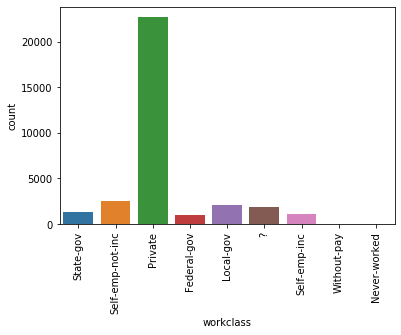

In [6]:
plot_categorical_distribution("workclass", 90)

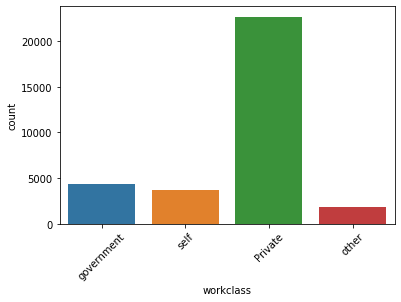

In [7]:
dataset = replace_on_condition(dataset, "workclass", "gov", "government")
dataset = replace_on_condition(dataset, "workclass", "Self", "self")
dataset = replace_on_condition(dataset, "workclass", "\?", "other")
dataset = replace_on_condition(dataset, "workclass", "pay", "other")
dataset = replace_on_condition(dataset, "workclass", "Never", "other")
plot_categorical_distribution("workclass", 45)

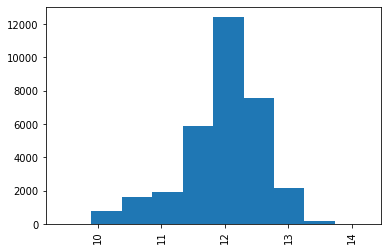

In [8]:
dataset["fnlwgt"] = np.log1p(dataset["fnlwgt"])

plot_numerical_distribution("fnlwgt", 90)

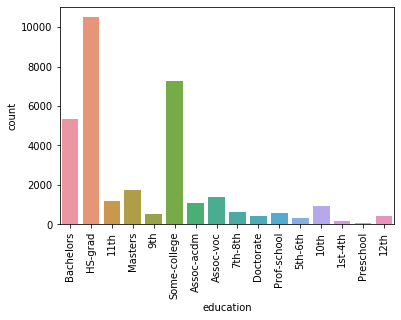

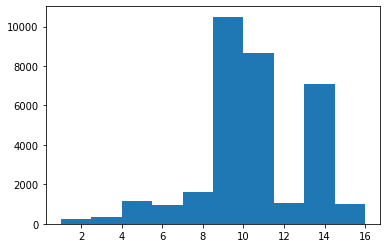

In [9]:
plot_categorical_distribution("education", 90)
plot_numerical_distribution("education num")

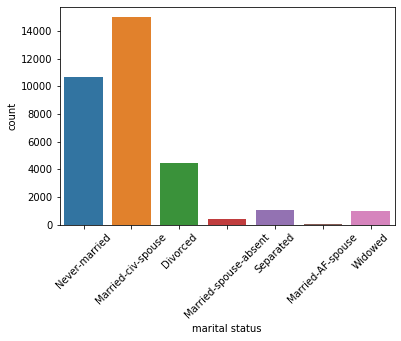

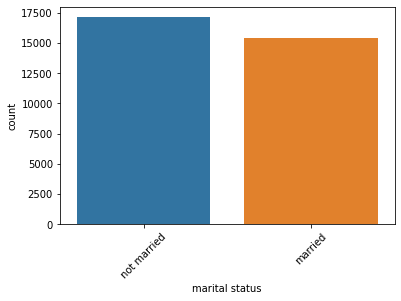

In [10]:
plot_categorical_distribution("marital status", 45)

dataset = replace_on_condition(dataset, "marital status", "Married", "married")
dataset = replace_on_condition(dataset, "marital status", "Never", "not married")
dataset = replace_on_condition(dataset, "marital status", "Divorced", "not married")
dataset = replace_on_condition(dataset, "marital status", "Widowed", "not married")
dataset = replace_on_condition(dataset, "marital status", "Separated", "not married")

plot_categorical_distribution("marital status", 45)

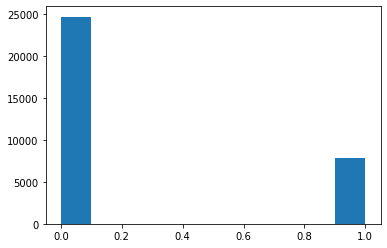

income bracket
0    75.919044
1    24.080956
dtype: float64


In [11]:
condition = dataset.loc[:, "income bracket"] == "<=50K"
dataset.loc[condition, "income bracket"] = 0.0
dataset.loc[np.logical_not(condition), "income bracket"] = 1.0

plot_numerical_distribution("income bracket")
print((dataset.groupby("income bracket").size() / dataset["income bracket"].count()) * 100)

/opt/conda/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


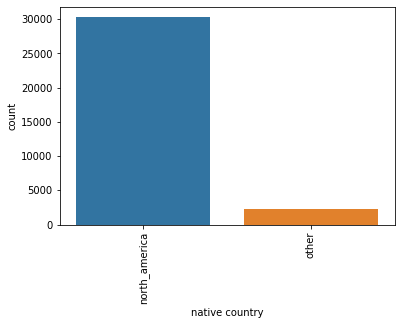

In [12]:
dataset = replace_native_country(dataset, north_america, "north_america")
dataset = replace_native_country(dataset, europe, "other")
dataset = replace_native_country(dataset, asia, "other")
dataset = replace_native_country(dataset, south_america, "other")
dataset = replace_native_country(dataset, other, "other")

plot_categorical_distribution("native country", 90)

In [13]:
for name in ["workclass", "education", "marital status", "native country", "m_f", "race", "occupation", "relationship"]:
    dataset = expand_category(dataset, name)

In [14]:
dataset.head()

,age,fnlwgt,education num,capital gain,capital loss,hours/week,income bracket,workclass_Private,workclass_government,workclass_other,workclass_self,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital status_married,marital status_not married,native country_north_america,native country_other,m_f_Female,m_f_Male,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,occupation_?,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,39,11.258253,13,2174,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,50,11.330348,13,0,0,13,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,38,12.281398,9,0,0,40,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,53,12.366157,7,0,0,40,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,28,12.732013,13,0,0,40,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [15]:
for name in ["age", "fnlwgt", "education num", "capital gain", "capital loss", "hours/week"]:
    dataset[name] = standardize_number(dataset, name)

In [16]:
dataset.head()

,age,fnlwgt,education num,capital gain,capital loss,hours/week,income bracket,workclass_Private,workclass_government,workclass_other,workclass_self,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital status_married,marital status_not married,native country_north_america,native country_other,m_f_Female,m_f_Male,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,occupation_?,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,0.030670,-1.150280,1.134721,0.148451,-0.216656,-0.035429,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.837096,-1.035977,1.134721,-0.145918,-0.216656,-2.222119,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,-0.042641,0.471860,-0.420053,-0.145918,-0.216656,-0.035429,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1.057031,0.606241,-1.197440,-0.145918,-0.216656,-0.035429,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,-0.775756,1.186286,1.134721,-0.145918,-0.216656,-0.035429,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


### Base NN model

In [37]:
def build(output_size):
    model = models.Sequential()
    model.add(layers.GaussianNoise(0.1))
    model.add(layers.Dense(units=200, activation=activations.tanh))
    model.add(layers.Dense(units=200, activation=activations.tanh))
    model.add(layers.Dense(units=output_size, activation=activations.sigmoid))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=0.005))

    return model

In [38]:
inputs = dataset.drop(["income bracket"], axis=1).to_numpy()
outputs = dataset["income bracket"].to_numpy()
outputs = np.expand_dims(outputs, 1)
outputs.shape


split_index = int(outputs.shape[0] * 0.1)

train_inputs = inputs[split_index:]
train_outputs = outputs[split_index:]
validation_inputs = inputs[:split_index]
validation_outputs = outputs[:split_index]

In [39]:
model = build(1)

epochs = 600
batch_size = 500

model.fit(train_inputs, 
          train_outputs,
          callbacks=[callbacks.EarlyStopping(mode="min", patience=20, restore_best_weights=True, monitor="val_loss")],
          validation_data=(validation_inputs, validation_outputs),
          batch_size=batch_size,
          epochs=epochs)

Train on 29305 samples, validate on 3256 samples
Epoch 1/600
29305/29305 [==============================] - 1s 34us/sample - loss: 0.3521 - val_loss: 0.3312
Epoch 2/600
29305/29305 [==============================] - 0s 16us/sample - loss: 0.3272 - val_loss: 0.3223
Epoch 3/600
29305/29305 [==============================] - 0s 15us/sample - loss: 0.3191 - val_loss: 0.3202
Epoch 4/600
29305/29305 [==============================] - 0s 15us/sample - loss: 0.3142 - val_loss: 0.3162
Epoch 5/600
29305/29305 [==============================] - 0s 15us/sample - loss: 0.3111 - val_loss: 0.3152
Epoch 6/600
29305/29305 [==============================] - 0s 16us/sample - loss: 0.3105 - val_loss: 0.3131
Epoch 7/600
29305/29305 [==============================] - 0s 15us/sample - loss: 0.3080 - val_loss: 0.3220
Epoch 8/600
29305/29305 [==============================] - 0s 15us/sample - loss: 0.3073 - val_loss: 0.3129
Epoch 9/600
29305/29305 [==============================] - 0s 15us/sample - loss: 0.304

16.5%


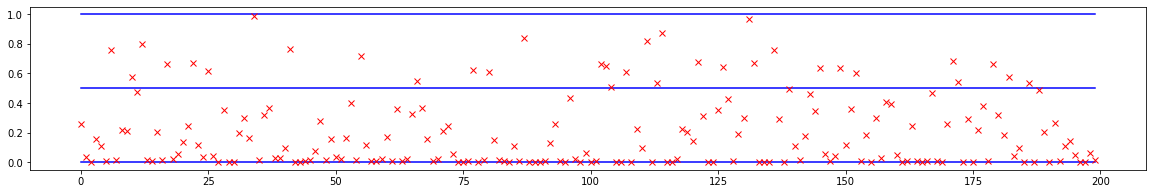

In [40]:
predict_and_plot(200, train_inputs, train_outputs)

16.5%


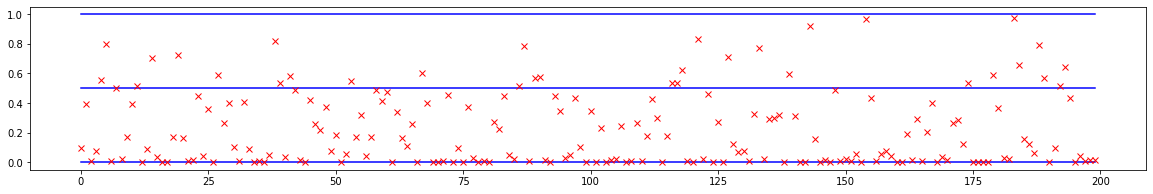

In [41]:
predict_and_plot(200, validation_inputs, validation_outputs)